### From the course
- Get pararellogram by making a scatterplot of mixed signals.
- Maximize the angle that gives highest variance, this gives rotation matrix U*.
- Finding the scaling of the principal components; variance along the two principal compoment axes, $\Sigma$. Undo the scaling.
- Rotation to produce a separable probability distribution (min. kurtosis).

### About vectors and matrices
Sort of confusing stuff in python. ICA in scikit works with signals in collumns, so one might see that dot products are reversed a bit. If you want to use np.vstack instead, a few matrices need to be transposed. The mixing matrix can be interpreted the same in either way. Although I here work with each signal being in a collumn, for me it is most easily understood if each signal is on each row of $\vec{s}$.

$ \vec{x} = A \vec{s}$, $\vec{s}$ is collumn with each row being a signal. $a_{1,i}$ gives contribution from signal $i$ to $x_i$.

x is zero mean and white, e.g. E($xx^T$) = I, (can always be achieved by centering and PCA/SVD). A is orthogonal, so $s = A^T x$.

### Mutual information (section just in case I need to google it later)
Define "differential entropy" and use it in a formula.
I(y) is always non-negative and measures the degree of dependence between the components of y. If the components of y are independent then I(y) = 0. ICA: look for A such that $I(A^T x)$ is minimized. 

### Continuing - copy paste from different sources.
- Among all random variables with equal variance, Gaussian variables have maximum entropy.

- ICA is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity.

- Non-gaussianity serves as a proxy for statistical independence, which is a very strong condition and requires infinite data to verify.

- Independent component analysis, or ICA, is a statistical technique that represents a multidimensional random vector as a linear combination of nongaussian random variables ('independent components') that are as independent as possible. 


We assume there are a set of independent sources in the data, but do not assume their exact properties. (Therefore, they may overlap in the frequency domain in contrast to Fourier techniques.) We then define **some measure** of independence and attempt to decorrelate the data by maximising this measure for (or between) projections onto each axis of the new space which we have transformed the data into. The sources are the data projected onto each of the new axes. Since we discover, rather than define the the new axes, this process is known as blind source separation. That is, we do not look for specific pre-defined components, such as the energy at a specific frequency, but rather, we allow the data to determine the components.

For ICA **this measure** is based on non-Gaussianity, such as kurtosis, and the axes are not necessarily orthogonal. Kurtosis is the fourth moment (mean, variance, and skewness are the first three) and is a measure of how non-Gaussian is a probability distribution function (PDF). Large positive values of kurtosis indicate a highly peaked PDF that is much narrower than a Gaussian. A negative kurtosis indicates a broad PDF that is much wider than a Gaussian. Our assumption is that if we maximize the non-Gaussianity of a set of signals, then they are maximally independent. This comes from the central limit theorem; if we keep adding independent signals together (which have highly non-Gaussian PDFs), we will eventually arrive at a Gaussian distribution. Conversely, if we break a Gaussian-like observation down into a set of non-Gaussian mixtures, each with distributions that are as non-Gaussian as possible, the individual signals will be independent. Therefore, kurtosis allows us to separate non-Gaussian independent sources, whereas variance allows us to separate independent Gaussian noise sources.

### FastICA

FastICA seeks an orthogonal rotation of prewhitened data, through a fixed-point iteration scheme, that maximizes a measure of non-Gaussianity of the rotated components. FastICA can also be alternatively derived as an approximative Newton iteration. A computationally highly efficient method for performing the estimation of ICA. It has been found in independent experiments to be 10-100 times faster than conventional gradient descent methods for ICA. 

### Projection pursuit
... Another advantage of the FastICA algorithm is that it can be used to perform projection pursuit as well, thus providing a general-purpose data analysis method that can be used both in an exploratory fashion and for estimation of independent components (or sources). 

Projection pursuit is a technique for exploratory data analysis with emphasis on visualization. It is  based on finding low-dimensional projections of multivariate data that show highly nongaussian distributions. Projection pursuit is technically very closely related to ICA.

### Insights so far
- Having 2 signals, one being equal to the other + a function, ICA will separate it out.
- Time shifts not significant if periodicity >> shift, it seems.

In [408]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA, PCA

## Create raw data

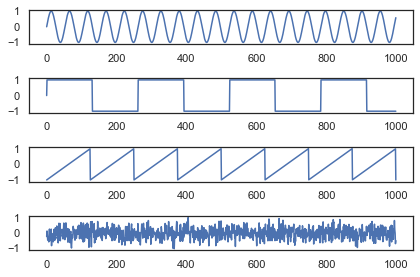

In [410]:
n_samples = 1000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(15 * time)                              # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))                      # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)              # Signal 3: saw tooth signal
s4 = np.random.normal(0,1,n_samples)                # signal 4: noise
s4 = s4/max(s4)    

clutter = np.zeros_like(s1)
clutter[400:600] = 1

S = np.c_[s1, s2, s3, s4]

for ii, s in enumerate(S.T,1):
    plt.subplot(4, 1, ii)
    plt.plot(s)
plt.tight_layout()

## Do pre-arrangement: mix, noise, scaling...

In [412]:
#r = np.roll(s1, 5)

#S = np.c_[s1, r]
#A = np.array([[0.7, 0.3], [0.3, 0.7]])

S = np.c_[s1, s2, s3]
A = np.array([[1.0, 0.6, 0.0], [0.3, 0.3, 0.3], [0.1, 0.1, 0.8]])


nc = 3

# better do as below instead of (A dot S.T).T
X = np.dot(S, A.T) # do it like this instead since it implies a transpose... wuh
X += 0.04 * np.random.normal(size=X.shape)
X /= X.std(axis=0)  # Standardize data

## Compute ICA

In [414]:
ica = FastICA(n_components=nc, whiten = True) 
# whiten=True, fun='logcosh', exp, cube. max_iter, tol, w_init
# n_components = Number of components to use. If none is passed, all are used.
 

Sica = ica.fit_transform(X)    # Reconstruct signals. 
#Potentially only use "fit", but not returning. Then "transform" to obtain Sica. "inverse transform" exists too.

#The pseudo-inverse of components_. It is the linear operator that maps independent sources to the data.
Aica = ica.mixing_             # Get estimated mixing matrix

# This is equal to the unmixing matrix when whiten is False, and equal to np.dot(unmixing_matrix, self.whitening_)
Unmixing = ica.components_ 

# Only if whiten is ‘True’. The pre-whitening matrix that projects data onto the first n_components PCs.
Whiten = ica.whitening_

# There is also a mean_

#### Original matrix
First row indicates multiple of signals that go into first sensor.

In [416]:
print(A)

[[1.  0.6 0. ]
 [0.3 0.3 0.3]
 [0.1 0.1 0.8]]


#### New mixing matrix 
Each row is still a sensor. Each collumn also represents a signal as before, but it may be in another order (collumns swapped around). And with another sign and scaling:

In [418]:
print(Aica)

[[ 2.27089032e+01 -2.20069469e+01 -2.39454031e-03]
 [ 1.54326115e+01 -2.45921857e+01  1.25323145e+01]
 [ 4.29134627e+00 -6.25254374e+00  3.07000007e+01]]


#### How to apply mixing and unmixing matrices
X @ Unmixing.T = S

... possibly with this first: np.dot(Unmixing, Whiten)

S @ A.T = X

The correct sign can be calculated from the mixing matrix. The correct scaling from var(x) = A*var(s)

### Comparison


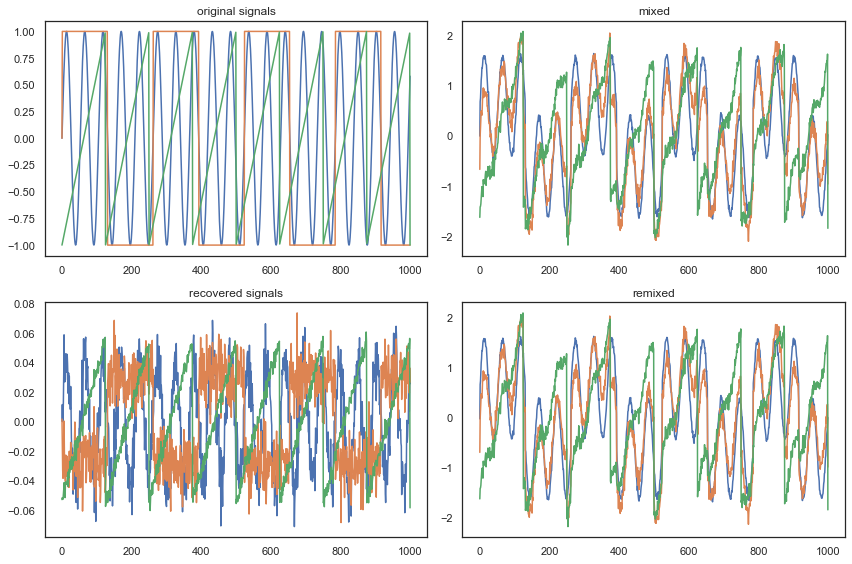

In [420]:
fig = plt.figure(figsize=(12, 8))  # Create figure and determine size
ax1 = plt.subplot(2, 2, 1)    # Create an elongated subplot using two grid indicies
ax2 = plt.subplot(2, 2, 2)         
ax3 = plt.subplot(2, 2, 3) 
ax4 = plt.subplot(2, 2, 4)

ax1.plot(S)
ax1.set_title('original signals')

ax2.plot(X)
ax2.set_title('mixed')

ax3.plot(Sica)
ax3.set_title('recovered signals')

ax4.plot(Sica @ Aica.T)
ax4.set_title('remixed')
 
plt.tight_layout()


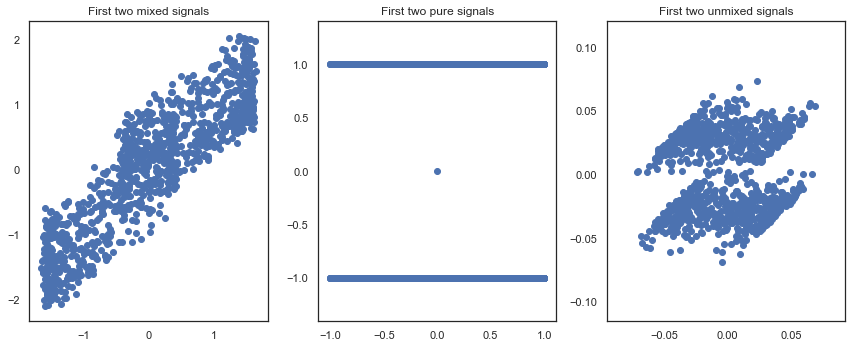

In [422]:
fig = plt.figure(figsize=(12, 5)) 
ax1 = plt.subplot(1, 3, 1)    
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.scatter(X.T[0],X.T[1])
ax1.set_aspect('equal', adjustable="datalim")
ax1.set_title('First two mixed signals')

ax2.scatter(S.T[0],S.T[1])
ax2.set_aspect('equal', adjustable="datalim")
ax2.set_title('First two pure signals')

ax3.scatter(Sica.T[0],Sica.T[1])
ax3.set_aspect('equal', adjustable="datalim")
ax3.set_title('First two unmixed signals')

plt.tight_layout()

## Original signals

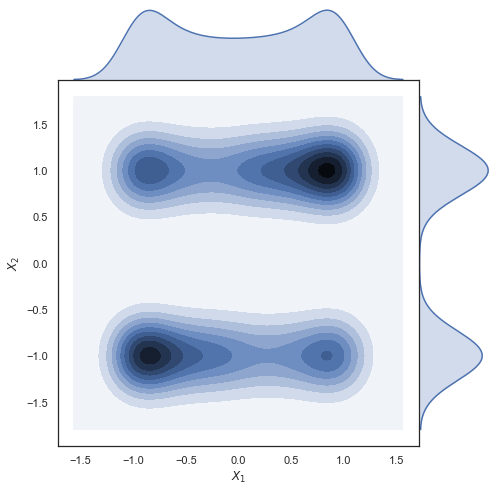

In [424]:
import pandas as pd
import seaborn as sns

sns.set(style="white")

x1 = pd.Series(S.T[0], name="$X_1$")
x2 = pd.Series(S.T[1], name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="kde", height=7, space=0)

## Mixed signals

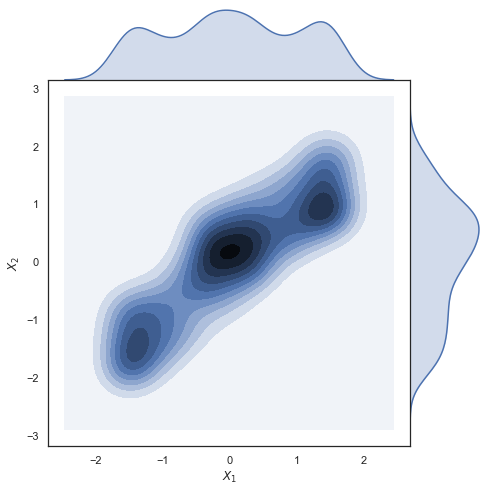

In [426]:
x1 = pd.Series(X.T[0], name="$X_1$")
x2 = pd.Series(X.T[1], name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="kde", height=7, space=0)

## Unmixed signals

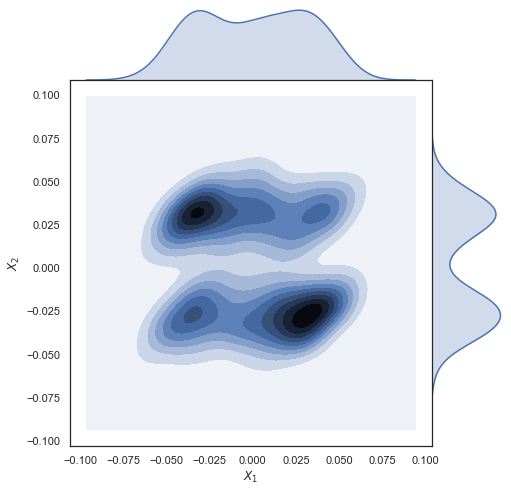

In [427]:
x1 = pd.Series(Sica.T[0], name="$X_1$")
x2 = pd.Series(Sica.T[1], name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(x1, x2, kind="kde", height=7, space=0)